# Fraud Detection Model - Credit Card Transactions
This notebook implements a comprehensive fraud detection system using machine learning. It includes:
- Data preprocessing and feature engineering
- Multiple sampling strategies for handling class imbalance
- Various machine learning models (LightGBM, XGBoost, CatBoost)
- Ensemble techniques (Voting, Stacking, Blending)
- Comprehensive model evaluation
- Visualization of results

Dataset Source: https://www.kaggle.com/datasets/priyamchoksi/credit-card-transactions-dataset


# 1. Install Necessary Package and Library

## Install Necessary Package

In [32]:
!pip install bayesian-optimization lightgbm xgboost catboost tensorflow scikit-learn pandas numpy matplotlib imblearn tabulate

## Import necessary library
Import all required libraries for data processing, modeling, and evaluation

In [33]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, matthews_corrcoef, roc_auc_score,
                           precision_recall_curve, auc, confusion_matrix,
                           roc_curve)
from sklearn.ensemble import IsolationForest, StackingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
warnings.filterwarnings('ignore')

# 2. Data Loading
Load the credit card transactions dataset directly into a DataFrame

In [34]:
df = pd.read_csv("credit_card_transactions.csv")

## Preview of the dataset
- Check the size of dataset
- List all the column name
- Check the missing value for each column

Number of Columns: 24
Number of Rows: 1296675


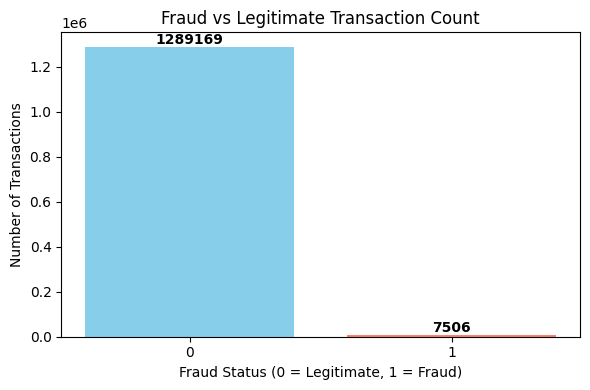

In [35]:
# Get the number of columns and rows
print("Number of Columns:", len(df.columns))
print("Number of Rows:", len(df))

#Preview of the data
df_types = pd.DataFrame(df.dtypes).reset_index()
df_types.columns = ['Feature Name', 'Data Type']
df_types

#Check missing value
missing_counts = df.isnull().sum()
missing_counts_df = pd.DataFrame(missing_counts).reset_index()
missing_counts_df.columns = ['Feature', 'Missing Value Count']
missing_counts_df

# Calculate the frequencies within the target variable
fraud = df["is_fraud"].value_counts()

# Plot bar chart
plt.figure(figsize=(6, 4))
bars = plt.bar(fraud.index.astype(str), fraud.values, color=['skyblue', 'salmon'])

# Add exact values on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{int(height)}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Customize plot
plt.xlabel("Fraud Status (0 = Legitimate, 1 = Fraud)")
plt.ylabel("Number of Transactions")
plt.title("Fraud vs Legitimate Transaction Count")
plt.tight_layout()
plt.show()

# 3. Data Preprocessing
This section handles:
- DateTime feature extraction
- Distance calculation between merchant and customer
- Dropping unnecessary columns
- Defining categorical and numerical features
- Creating preprocessing pipeline

## Preparing Data


In [36]:
# Convert transaction time to datetime and extract useful features
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['hour'] = df['trans_date_trans_time'].dt.hour
df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek
df['month'] = df['trans_date_trans_time'].dt.month

# Calculate distance between merchant and customer
df['distance'] = np.sqrt((df['lat']-df['merch_lat'])**2 + (df['long']-df['merch_long'])**2)

# Drop unnecessary columns
df.drop(['Unnamed: 0', 'trans_date_trans_time', 'trans_num', 'first', 'last', 'street',
         'city', 'state', 'zip', 'lat', 'long', 'merch_lat', 'merch_long', 'merch_zipcode',
         'unix_time', 'dob'], axis=1, inplace=True)

# Define categorical and numerical features
categorical_features = ['merchant', 'category', 'gender', 'job']
numerical_features = ['amt', 'city_pop', 'hour', 'day_of_week', 'month', 'distance']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# 4. Data Splitting
Split data into features and target, then into train/test sets

In [37]:
# Drop rows where 'is_fraud' is NaN
df = df.dropna(subset=['is_fraud'])

# Split data into features and target
X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

# Calculate fraud ratio for class weighting
fraud_ratio = y.mean()

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Get indices of categorical features for CatBoost
cat_features_indices = [i for i, col in enumerate(X.columns) if col in categorical_features]

# 5. Model Parameters
Define parameters for all models

## Define model parameters : LightGBM , XGBoost, CatBoost

In [38]:
lgbm_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'n_estimators': 100,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,
    'n_jobs': -1,
    'class_weight': 'balanced'
}

xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'n_estimators': 100,
    'learning_rate': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0.1,
    'min_child_weight': 1,
    'random_state': 42,
    'n_jobs': -1,
    'scale_pos_weight': (1 - fraud_ratio) / fraud_ratio  # Handle class imbalance
}

catboost_params = {
    'iterations': 100,
    'learning_rate': 0.1,
    'depth': 6,
    'l2_leaf_reg': 3,
    'random_seed': 42,
    'thread_count': -1,
    'auto_class_weights': 'Balanced',
    'verbose': False
}

# 6. Sampling Strategy Evaluation
Compare different approaches for handling class imbalance by three different sampling strategies: Random Undersampling, SMOTE, Bayesian Optimization

## Define three different sampling strategies

In [39]:
sampling_strategies = {
    'SMOTE Only': Pipeline([
        ('preprocessor', preprocessor),
        ('sampling', SMOTE(sampling_strategy=0.1, random_state=42)),
        ('classifier', LGBMClassifier(**lgbm_params))
    ]),
    'Random Undersampling Only': Pipeline([
        ('preprocessor', preprocessor),
        ('sampling', RandomUnderSampler(sampling_strategy=0.5, random_state=42)),
        ('classifier', LGBMClassifier(**lgbm_params))
    ]),
    'Bayesian Optimization Only': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LGBMClassifier(**lgbm_params))  # Using class_weight='balanced' from params
    ])
}

## Define evaluate_model function

In [40]:
def evaluate_model(model, X_test, y_test, model_name='Model'):
    try:
        if 'Voting' in model_name:
            # For VotingClassifier, we need to transform the test data first
            X_test_transformed = transformer.transform(X_test)
            y_pred_proba = model.predict_proba(X_test_transformed)[:, 1]
        else:
            try:
                y_pred_proba = model.predict_proba(X_test)[:, 1]
            except:
                # For CatBoost with categorical features
                y_pred_proba = model.predict_proba(
                    X_test,
                    thread_count=-1,
                    verbose=False
                )[:, 1]
    except Exception as e:
        print(f"Error in {model_name}: {str(e)}")
        return None

    # Ensure we have predictions before proceeding
    if 'y_pred_proba' not in locals():
        print(f"Failed to get predictions for {model_name}")
        return None

    y_pred = (y_pred_proba > 0.5).astype(int)

    # Calculate all metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Precision-Recall Curve and AUC
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall_curve, precision_curve)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Additional metrics
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

    # Print comprehensive report
    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f} | Recall (Sensitivity): {recall:.4f}")
    print(f"Specificity: {specificity:.4f} | NPV: {npv:.4f}")
    print(f"F1 Score: {f1:.4f} | MCC: {mcc:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f} | PR-AUC: {pr_auc:.4f}")
    print(f"False Positive Rate: {fpr:.4f} | False Negative Rate: {fnr:.4f}")
    print(f"Confusion Matrix:\n{cm}")

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Legitimate', 'Fraud'],
                yticklabels=['Legitimate', 'Fraud'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # Store curve data for later visualization
    fpr_curve, tpr_curve, _ = roc_curve(y_test, y_pred_proba)

    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'Specificity': specificity,
        'NPV': npv,
        'F1': f1,
        'MCC': mcc,
        'ROC-AUC': roc_auc,
        'PR-AUC': pr_auc,
        'FPR': fpr,
        'FNR': fnr,
        'curve_data': {
            'fpr': fpr_curve,
            'tpr': tpr_curve,
            'precision': precision_curve,
            'recall': recall_curve,
            'auc': roc_auc,
            'pr_auc': pr_auc
        }
    }

### Evaluate each sampling strategy and Plot the comparison


Evaluating SMOTE Only...
[LightGBM] [Info] Number of positive: 90241, number of negative: 902418
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.490659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23610
[LightGBM] [Info] Number of data points in the train set: 992659, number of used features: 1209
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000

SMOTE Only Performance:
Accuracy: 0.9848
Precision: 0.2686 | Recall (Sensitivity): 0.9387
Specificity: 0.9851 | NPV: 0.9996
F1 Score: 0.4177 | MCC: 0.4978
ROC-AUC: 0.9966 | PR-AUC: 0.8250
False Positive Rate: 0.0149 | False Negative Rate: 0.0613
Confusion Matrix:
[[380994   5757]
 [   138   2114]]


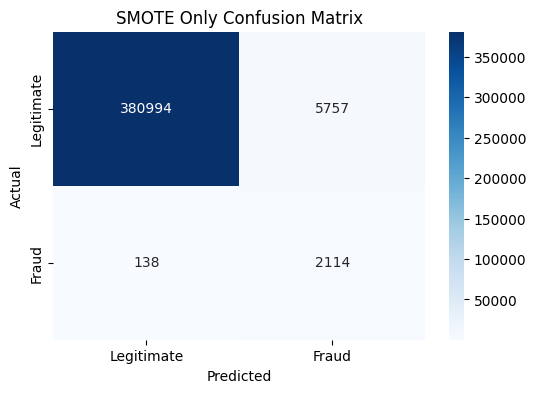


Evaluating Random Undersampling Only...
[LightGBM] [Info] Number of positive: 5254, number of negative: 10508
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2242
[LightGBM] [Info] Number of data points in the train set: 15762, number of used features: 722
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Random Undersampling Only Performance:
Accuracy: 0.9762
Precision: 0.1923 | Recall (Sensitivity): 0.9742
Specificity: 0.9762 | NPV: 0.9998
F1 Score: 0.3213 | MCC: 0.4274
ROC-AUC: 0.9973 | PR-AUC: 0.8374
False Positive Rate: 0.0238 | False Negative Rate: 0.0258
Confusion Matrix:
[[377538   9213]
 [    58   2194]]


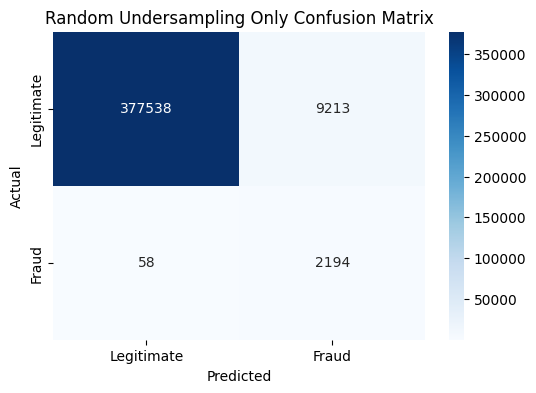


Evaluating Bayesian Optimization Only...
[LightGBM] [Info] Number of positive: 5254, number of negative: 902418
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010786 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3179
[LightGBM] [Info] Number of data points in the train set: 907672, number of used features: 1191
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000

Bayesian Optimization Only Performance:
Accuracy: 0.9790
Precision: 0.2124 | Recall (Sensitivity): 0.9707
Specificity: 0.9790 | NPV: 0.9998
F1 Score: 0.3485 | MCC: 0.4489
ROC-AUC: 0.9975 | PR-AUC: 0.8309
False Positive Rate: 0.0210 | False Negative Rate: 0.0293
Confusion Matrix:
[[378645   8106]
 [    66   2186]]


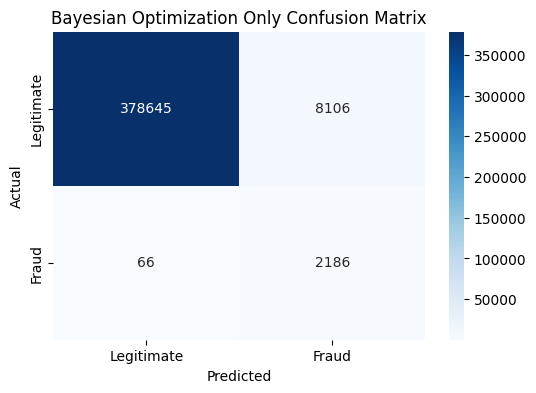


Sampling Strategy Comparison:
                            Accuracy  Precision    Recall        F1       MCC  \
Model                                                                           
SMOTE Only                  0.984846   0.268581  0.938721  0.417663  0.497785   
Random Undersampling Only   0.976167   0.192338  0.974245  0.321253  0.427383   
Bayesian Optimization Only  0.978992   0.212398  0.970693  0.348533  0.448950   

                             ROC-AUC    PR-AUC  Combined_Score  
Model                                                           
SMOTE Only                  0.996623  0.825028        0.785549  
Random Undersampling Only   0.997342  0.837405        0.749150  
Bayesian Optimization Only  0.997486  0.830940        0.760024  


<Figure size 1200x600 with 0 Axes>

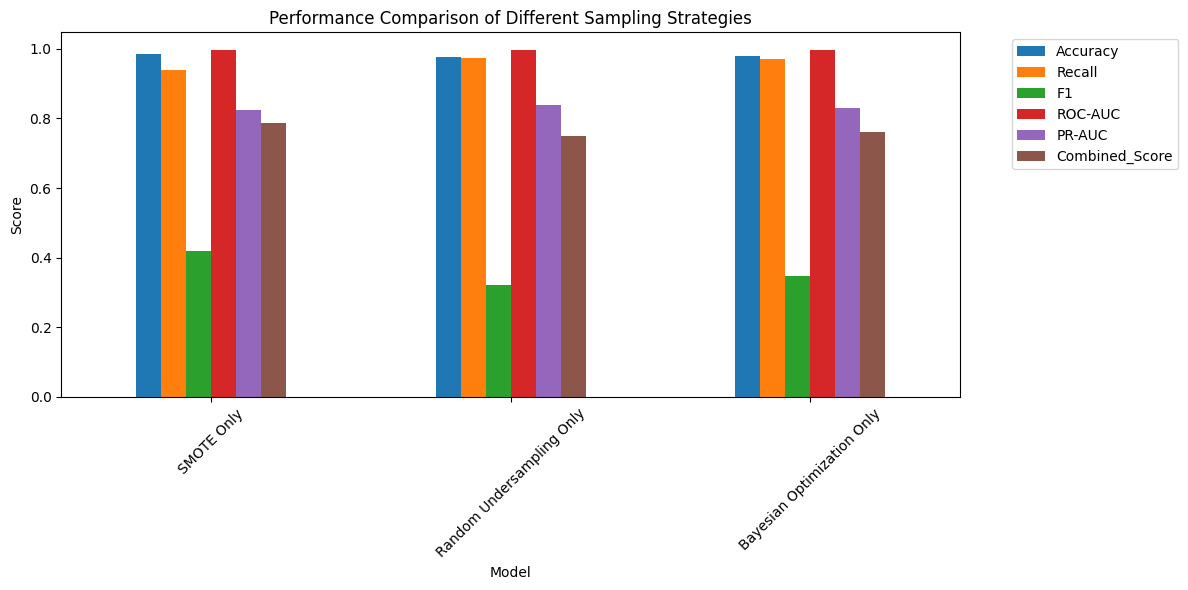

In [41]:
# Evaluate each sampling strategy
sampling_results = []
for name, model in sampling_strategies.items():
    print(f"\nEvaluating {name}...")
    model.fit(X_train, y_train)
    result = evaluate_model(model, X_test, y_test, name)
    sampling_results.append(result)

# Create comparison DataFrame
sampling_df = pd.DataFrame(sampling_results).drop(columns=['curve_data'])
sampling_df.set_index('Model', inplace=True)

# Calculate combined score for sampling strategies
sampling_df['Combined_Score'] = (0.25 * sampling_df['F1'] +
                               0.25 * sampling_df['MCC'] +
                               0.20 * sampling_df['ROC-AUC'] +
                               0.20 * sampling_df['PR-AUC'] +
                               0.10 * sampling_df['Accuracy'] +
                               0.10 * sampling_df['Recall'])

# Display comparison results
print("\n" + "="*80)
print("Sampling Strategy Comparison:")
print("="*80)
print(sampling_df[['Accuracy', 'Precision', 'Recall', 'F1', 'MCC', 'ROC-AUC', 'PR-AUC', 'Combined_Score']])
print("="*80)

# Plot comparison
plt.figure(figsize=(12, 6))
metrics = ['Accuracy', 'Recall', 'F1', 'ROC-AUC', 'PR-AUC', 'Combined_Score']
sampling_df[metrics].plot(kind='bar', figsize=(12, 6))
plt.title('Performance Comparison of Different Sampling Strategies')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Select the best sampling strategy - choose the best one to apply for all models

In [42]:
# Select the best sampling strategy
best_sampling_name = sampling_df['Combined_Score'].idxmax()
best_sampling = sampling_strategies[best_sampling_name].named_steps['sampling'] if 'sampling' in sampling_strategies[best_sampling_name].named_steps else None
print(f"\nSelected best sampling strategy: {best_sampling_name}")


Selected best sampling strategy: SMOTE Only


#  7. Create a base pipeline with the best sampling strategy
 Create pipelines with the best sampling strategy and define all models

In [43]:
# Create a base pipeline with the best sampling strategy
if best_sampling_name == 'Bayesian Optimization Only':
    base_pipeline = Pipeline([
        ('preprocessor', preprocessor)
    ])
else:
    base_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('sampling', best_sampling)
    ])

# Define models with the best sampling strategy
lgbm_pipe = Pipeline([
    *base_pipeline.steps,
    ('classifier', LGBMClassifier(**lgbm_params))
])

xgb_pipe = Pipeline([
    *base_pipeline.steps,
    ('classifier', XGBClassifier(**xgb_params))
])

catboost_pipe = Pipeline([
    *base_pipeline.steps,
    ('classifier', CatBoostClassifier(**catboost_params))
])

# Add Logistic Regression model
logreg_pipe = Pipeline([
    *base_pipeline.steps,
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])




## Define ensemble models - Voting Classifier, Stacking, Blending


### Voting

In [44]:
# First create fitted estimators for VotingClassifier
def get_fitted_estimator(pipe, X_train, y_train):
    """Helper function to fit a pipeline and return the classifier"""
    pipe.fit(X_train, y_train)
    return pipe.named_steps['classifier']

# Fit the base models first
lgbm_classifier = get_fitted_estimator(lgbm_pipe, X_train, y_train)
xgb_classifier = get_fitted_estimator(xgb_pipe, X_train, y_train)
catboost_classifier = get_fitted_estimator(catboost_pipe, X_train, y_train)
logreg_classifier = get_fitted_estimator(logreg_pipe, X_train, y_train)

# Now define VotingClassifiers with fitted estimators
# Create new VotingClassifiers that will be properly fitted
voting_lgbm_xgb = VotingClassifier(
    estimators=[
        ('lgbm', LGBMClassifier(**lgbm_params)),
        ('xgb', XGBClassifier(**xgb_params))
    ],
    voting='soft'
)

voting_lgbm_cat = VotingClassifier(
    estimators=[
        ('lgbm', LGBMClassifier(**lgbm_params)),
        ('cat', CatBoostClassifier(**catboost_params))
    ],
    voting='soft'
)

voting_lgbm_cat_xgb = VotingClassifier(
    estimators=[
        ('lgbm', LGBMClassifier(**lgbm_params)),
        ('xgb', XGBClassifier(**xgb_params)),
        ('cat', CatBoostClassifier(**catboost_params))
        ],
    voting='soft'
)


voting_all = VotingClassifier(
    estimators=[
        ('lgbm', LGBMClassifier(**lgbm_params)),
        ('xgb', XGBClassifier(**xgb_params)),
        ('cat', CatBoostClassifier(**catboost_params)),
        ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
    ],
    voting='soft'
)


[LightGBM] [Info] Number of positive: 90241, number of negative: 902418
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.510922 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23610
[LightGBM] [Info] Number of data points in the train set: 992659, number of used features: 1209
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


### Stacking

In [45]:
# Define base estimators for stacking
base_estimators = [
    ('lgbm', lgbm_pipe),
    ('xgb', xgb_pipe),
    ('cat', catboost_pipe),
    ('logreg', logreg_pipe)
]

# Create stacking classifiers
stack_lgbm_xgb = StackingClassifier(
    estimators=[('lgbm', lgbm_pipe), ('xgb', xgb_pipe)],
    final_estimator=LogisticRegression(class_weight='balanced', max_iter=1000),
    passthrough=False  # Don't include original features
)

stack_lgbm_cat = StackingClassifier(
    estimators=[('lgbm', lgbm_pipe), ('cat', catboost_pipe)],
    final_estimator=LogisticRegression(class_weight='balanced', max_iter=1000),
    passthrough=False
)

stack_lgbm_cat_xgb = StackingClassifier(
    estimators=[('lgbm', lgbm_pipe), ('cat', catboost_pipe), ('xgb', xgb_pipe)],
    final_estimator=LogisticRegression(class_weight='balanced', max_iter=1000),
    passthrough=False
)

stack_all = StackingClassifier(
    estimators=base_estimators,  # Uses all 4 models
    final_estimator=LogisticRegression(class_weight='balanced', max_iter=1000),
    passthrough=False
)

# Create separate pipelines for transformation and sampling
transformer = Pipeline([
    ('preprocessor', preprocessor)
])

# Then when you need to transform data for stacking:
X_train_transformed = transformer.transform(X_train)
X_test_transformed = transformer.transform(X_test)

# And keep your sampling pipeline separate for training
if best_sampling_name == 'Bayesian Optimization Only':
    sampling_pipeline = Pipeline([
        ('transformer', transformer)
    ])
else:
    sampling_pipeline = Pipeline([
        ('transformer', transformer),
        ('sampling', best_sampling)
    ])
def custom_stacking(models, X_train, y_train, X_test, final_estimator=None):
    """Custom implementation of stacking to avoid sklearn tag issues"""
    if final_estimator is None:
        final_estimator = LogisticRegression(class_weight='balanced', max_iter=1000)

    # Get predictions from each model
    predictions = []
    for name, model in models.items():
        # For pipelines, we need to use the fitted model directly
        if hasattr(model, 'named_steps'):
            # Get the classifier from the pipeline
            classifier = model.named_steps['classifier']
            # Get the transformer from the pipeline
            transformer = model.named_steps['preprocessor']
            # Transform the data
            X_train_trans = transformer.transform(X_train)
            preds = classifier.predict_proba(X_train_trans)[:, 1]
        else:
            preds = model.predict_proba(X_train)[:, 1]
        predictions.append(preds)

    # Stack predictions
    X_meta = np.column_stack(predictions)

    # Train final estimator
    final_estimator.fit(X_meta, y_train)

    # Get test predictions
    test_predictions = []
    for name, model in models.items():
        if hasattr(model, 'named_steps'):
            classifier = model.named_steps['classifier']
            transformer = model.named_steps['preprocessor']
            X_test_trans = transformer.transform(X_test)
            preds = classifier.predict_proba(X_test_trans)[:, 1]
        else:
            preds = model.predict_proba(X_test)[:, 1]
        test_predictions.append(preds)

    X_test_meta = np.column_stack(test_predictions)

    # Return final predictions
    return final_estimator.predict_proba(X_test_meta)[:, 1]

# Create model dictionaries for stacking
stack_lgbm_xgb = {'lgbm': lgbm_pipe, 'xgb': xgb_pipe}
stack_lgbm_cat = {'lgbm': lgbm_pipe, 'cat': catboost_pipe}
stack_lgbm_cat_xgb = {'lgbm': lgbm_pipe, 'cat': catboost_pipe,'xgb': xgb_pipe}
stack_all = {'lgbm': lgbm_pipe, 'xgb': xgb_pipe, 'cat': catboost_pipe, 'logreg': logreg_pipe}

### Blending

In [46]:
# Blending models (custom implementation)
def blend_models(models, X, y, X_val, val_size=0.2, random_state=42):
    # Split training data for blending
    X_train_blend, X_val_blend, y_train_blend, y_val_blend = train_test_split(
        X, y, test_size=val_size, stratify=y, random_state=random_state
    )

    # Train models and get predictions
    val_preds = []
    test_preds = []

    for name, model in models.items():
        model.fit(X_train_blend, y_train_blend)
        val_preds.append(model.predict_proba(X_val_blend)[:, 1])
        test_preds.append(model.predict_proba(X_val)[:, 1])

    # Stack predictions
    X_meta = np.column_stack(val_preds)
    X_test_meta = np.column_stack(test_preds)

    # Train meta-model
    meta_model = LogisticRegression(class_weight='balanced', max_iter=1000)
    meta_model.fit(X_meta, y_val_blend)

    # Return blended predictions
    return meta_model.predict_proba(X_test_meta)[:, 1]

# Create blending models (these will be fit during evaluation)
blend_lgbm_xgb = {'lgbm': lgbm_pipe, 'xgb': xgb_pipe}
blend_lgbm_cat = {'lgbm': lgbm_pipe, 'cat': catboost_pipe}
blend_lgbm_cat_xgb = {'lgbm': lgbm_pipe, 'cat': catboost_pipe, 'xgb': xgb_pipe}
blend_all = {'lgbm': lgbm_pipe, 'xgb': xgb_pipe, 'cat': catboost_pipe, 'logreg': logreg_pipe}

# 8. Model Training
Train all defined models

Evaluate stacking models first with untransformed data

In [47]:
'''
# Evaluate stacking models first with untransformed data
stacking_results = []
for name, model_dict in [('Stacking (LGBM+XGB)', stack_lgbm_xgb),
                         ('Stacking (LGBM+Cat)', stack_lgbm_cat),
                         ('Stacking (LGBM+Cat+XGB)', stack_lgbm_cat_xgb)
                         ('Stacking (All)', stack_all)]:
    print(f"\nEvaluating {name}...")
    try:
        y_pred_proba = custom_stacking(model_dict, X_train, y_train, X_test)
        y_pred = (y_pred_proba > 0.5).astype(int)

        class DummyModel:
            def predict_proba(self, X):
                return np.column_stack([1-y_pred_proba, y_pred_proba])
            def predict(self, X):
                return y_pred

        result = evaluate_model(DummyModel(), X_test, y_test, name)
        if result is not None:
            stacking_results.append(result)
            all_curves[name] = result['curve_data']
    except Exception as e:
        print(f"Error evaluating {name}: {str(e)}")
        continue
'''

'\n# Evaluate stacking models first with untransformed data\nstacking_results = []\nfor name, model_dict in [(\'Stacking (LGBM+XGB)\', stack_lgbm_xgb),\n                         (\'Stacking (LGBM+Cat)\', stack_lgbm_cat),\n                         (\'Stacking (LGBM+Cat+XGB)\', stack_lgbm_cat_xgb)\n                         (\'Stacking (All)\', stack_all)]:\n    print(f"\nEvaluating {name}...")\n    try:\n        y_pred_proba = custom_stacking(model_dict, X_train, y_train, X_test)\n        y_pred = (y_pred_proba > 0.5).astype(int)\n\n        class DummyModel:\n            def predict_proba(self, X):\n                return np.column_stack([1-y_pred_proba, y_pred_proba])\n            def predict(self, X):\n                return y_pred\n\n        result = evaluate_model(DummyModel(), X_test, y_test, name)\n        if result is not None:\n            stacking_results.append(result)\n            all_curves[name] = result[\'curve_data\']\n    except Exception as e:\n        print(f"Error eval

## Train Model

In [48]:
models = {
    'LightGBM': lgbm_pipe,
    'XGBoost': xgb_pipe,
    'CatBoost': catboost_pipe,
    'Logistic Regression': logreg_pipe,
    'Voting (LGBM+XGB)': voting_lgbm_xgb,
    'Voting (LGBM+Cat)': voting_lgbm_cat,
    'Voting (LGBM+Cat+XGB)': voting_lgbm_cat_xgb,
    'Voting (All)': voting_all,
    'Stacking (LGBM+XGB)': stack_lgbm_xgb,
    'Stacking (LGBM+Cat)': stack_lgbm_cat,
    'Stacking (LGBM+Cat+XGB)': stack_lgbm_cat_xgb,
    'Stacking (All)': stack_all,
    'Blending (LGBM+XGB)': blend_lgbm_xgb,
    'Blending (LGBM+Cat)': blend_lgbm_cat,
    'Blending (LGBM+Cat+XGB)': blend_lgbm_cat_xgb,
    'Blending (All)': blend_all
}

# First transform the training data for VotingClassifier
X_train_transformed = transformer.transform(X_train)

print("\nTraining models...")
for name, model in models.items():
    print(f"\nTraining {name}...")
    if 'Stacking' in name or 'Blending' in name:
        # Stacking and blending models are handled differently in evaluation
        continue
    elif 'Voting' in name:
        # Fit VotingClassifiers with transformed data
        model.fit(X_train_transformed, y_train)
    else:
        model.fit(X_train, y_train)


Training models...

Training LightGBM...
[LightGBM] [Info] Number of positive: 90241, number of negative: 902418
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.519479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23610
[LightGBM] [Info] Number of data points in the train set: 992659, number of used features: 1209
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000

Training XGBoost...

Training CatBoost...

Training Logistic Regression...

Training Voting (LGBM+XGB)...
[LightGBM] [Info] Number of positive: 5254, number of negative: 902418
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=

# 9. Model Evaluation

## Evaluate All Model


LightGBM Performance:
Accuracy: 0.9848
Precision: 0.2686 | Recall (Sensitivity): 0.9387
Specificity: 0.9851 | NPV: 0.9996
F1 Score: 0.4177 | MCC: 0.4978
ROC-AUC: 0.9966 | PR-AUC: 0.8250
False Positive Rate: 0.0149 | False Negative Rate: 0.0613
Confusion Matrix:
[[380994   5757]
 [   138   2114]]


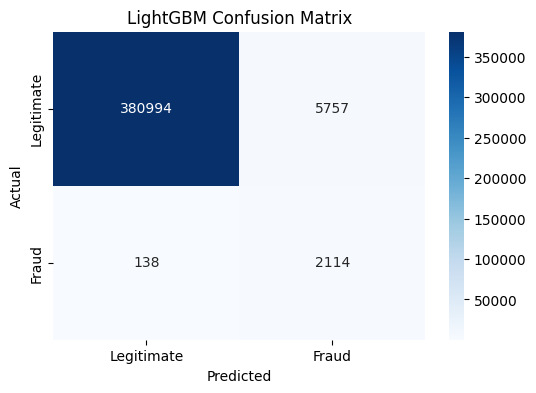


XGBoost Performance:
Accuracy: 0.9368
Precision: 0.0834 | Recall (Sensitivity): 0.9925
Specificity: 0.9365 | NPV: 1.0000
F1 Score: 0.1538 | MCC: 0.2782
ROC-AUC: 0.9966 | PR-AUC: 0.8208
False Positive Rate: 0.0635 | False Negative Rate: 0.0075
Confusion Matrix:
[[362178  24573]
 [    17   2235]]


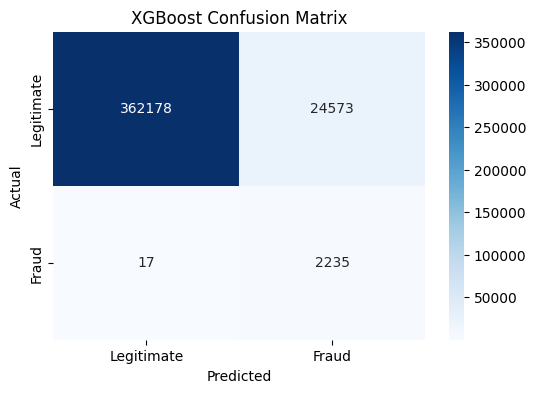


CatBoost Performance:
Accuracy: 0.9871
Precision: 0.3000 | Recall (Sensitivity): 0.9263
Specificity: 0.9874 | NPV: 0.9996
F1 Score: 0.4532 | MCC: 0.5232
ROC-AUC: 0.9962 | PR-AUC: 0.8241
False Positive Rate: 0.0126 | False Negative Rate: 0.0737
Confusion Matrix:
[[381884   4867]
 [   166   2086]]


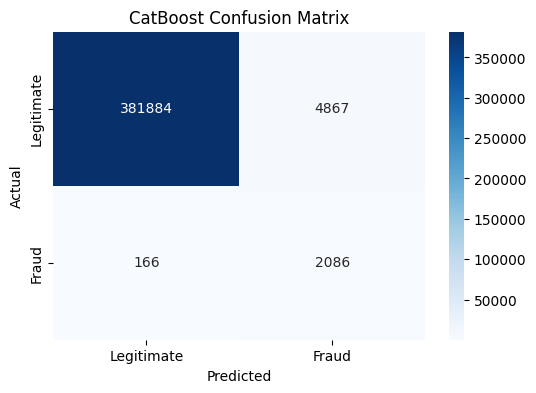


Logistic Regression Performance:
Accuracy: 0.8817
Precision: 0.0379 | Recall (Sensitivity): 0.7980
Specificity: 0.8822 | NPV: 0.9987
F1 Score: 0.0724 | MCC: 0.1578
ROC-AUC: 0.9169 | PR-AUC: 0.1732
False Positive Rate: 0.1178 | False Negative Rate: 0.2020
Confusion Matrix:
[[341186  45565]
 [   455   1797]]


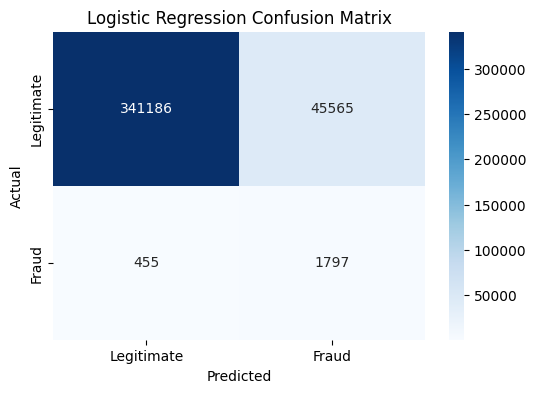


Voting (LGBM+XGB) Performance:
Accuracy: 0.9813
Precision: 0.2321 | Recall (Sensitivity): 0.9676
Specificity: 0.9814 | NPV: 0.9998
F1 Score: 0.3743 | MCC: 0.4691
ROC-AUC: 0.9976 | PR-AUC: 0.8442
False Positive Rate: 0.0186 | False Negative Rate: 0.0324
Confusion Matrix:
[[379540   7211]
 [    73   2179]]


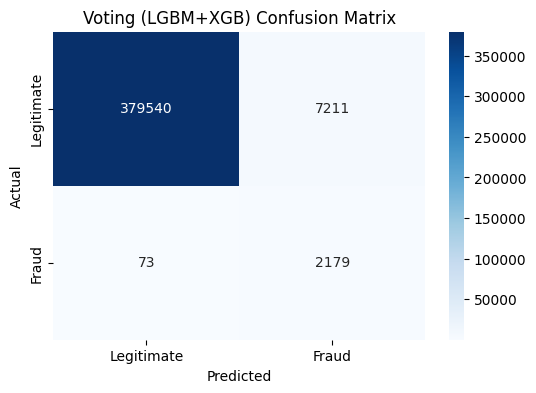


Voting (LGBM+Cat) Performance:
Accuracy: 0.9790
Precision: 0.2123 | Recall (Sensitivity): 0.9711
Specificity: 0.9790 | NPV: 0.9998
F1 Score: 0.3484 | MCC: 0.4489
ROC-AUC: 0.9975 | PR-AUC: 0.8224
False Positive Rate: 0.0210 | False Negative Rate: 0.0289
Confusion Matrix:
[[378635   8116]
 [    65   2187]]


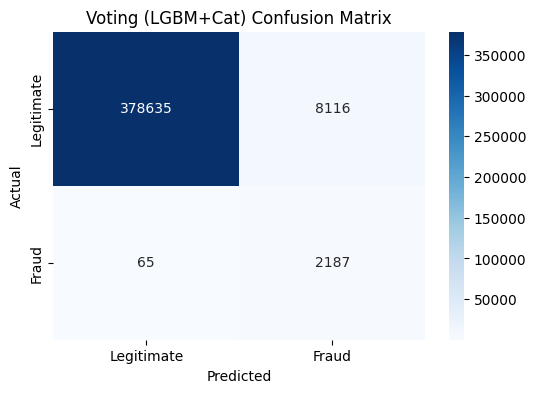


Voting (LGBM+Cat+XGB) Performance:
Accuracy: 0.9808
Precision: 0.2279 | Recall (Sensitivity): 0.9689
Specificity: 0.9809 | NPV: 0.9998
F1 Score: 0.3690 | MCC: 0.4651
ROC-AUC: 0.9976 | PR-AUC: 0.8386
False Positive Rate: 0.0191 | False Negative Rate: 0.0311
Confusion Matrix:
[[379360   7391]
 [    70   2182]]


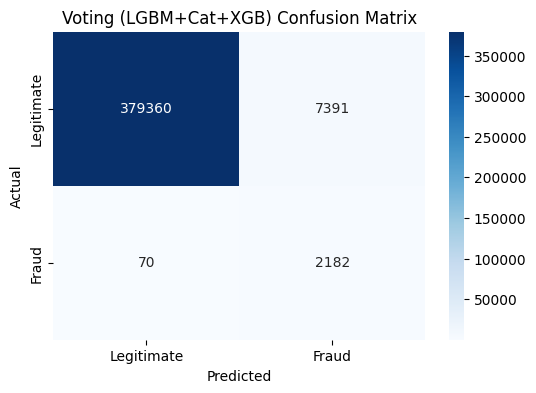


Voting (All) Performance:
Accuracy: 0.9832
Precision: 0.2522 | Recall (Sensitivity): 0.9645
Specificity: 0.9833 | NPV: 0.9998
F1 Score: 0.3998 | MCC: 0.4887
ROC-AUC: 0.9966 | PR-AUC: 0.7179
False Positive Rate: 0.0167 | False Negative Rate: 0.0355
Confusion Matrix:
[[380310   6441]
 [    80   2172]]


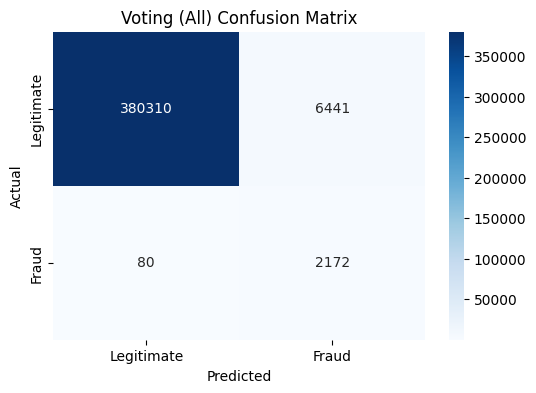

[LightGBM] [Info] Number of positive: 72193, number of negative: 721934
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.236259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24551
[LightGBM] [Info] Number of data points in the train set: 794127, number of used features: 1209
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000

Blending (LGBM+XGB) Performance:
Accuracy: 0.9718
Precision: 0.1673 | Recall (Sensitivity): 0.9742
Specificity: 0.9718 | NPV: 0.9998
F1 Score: 0.2856 | MCC: 0.3977
ROC-AUC: 0.9970 | PR-AUC: 0.8316
False Positive Rate: 0.0282 | False Negative Rate: 0.0258
Confusion Matrix:
[[375833  10918]
 [    58   2194]]


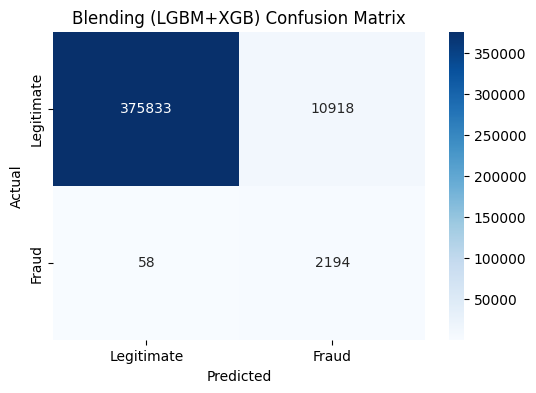

[LightGBM] [Info] Number of positive: 72193, number of negative: 721934
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.261142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24551
[LightGBM] [Info] Number of data points in the train set: 794127, number of used features: 1209
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000

Blending (LGBM+Cat) Performance:
Accuracy: 0.9785
Precision: 0.2069 | Recall (Sensitivity): 0.9547
Specificity: 0.9787 | NPV: 0.9997
F1 Score: 0.3400 | MCC: 0.4391
ROC-AUC: 0.9966 | PR-AUC: 0.8264
False Positive Rate: 0.0213 | False Negative Rate: 0.0453
Confusion Matrix:
[[378507   8244]
 [   102   2150]]


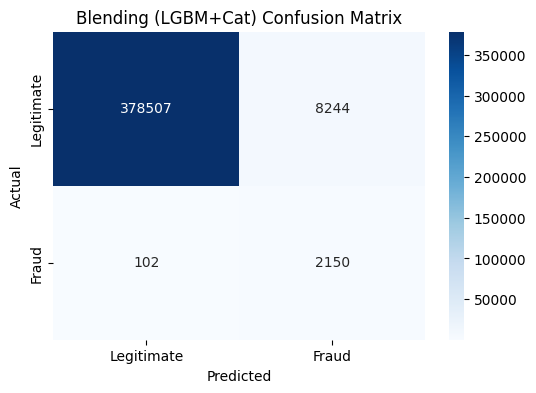

[LightGBM] [Info] Number of positive: 72193, number of negative: 721934
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.276724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24551
[LightGBM] [Info] Number of data points in the train set: 794127, number of used features: 1209
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000

Blending (LGBM+Cat+XGB) Performance:
Accuracy: 0.9717
Precision: 0.1670 | Recall (Sensitivity): 0.9747
Specificity: 0.9717 | NPV: 0.9998
F1 Score: 0.2852 | MCC: 0.3974
ROC-AUC: 0.9969 | PR-AUC: 0.8267
False Positive Rate: 0.0283 | False Negative Rate: 0.0253
Confusion Matrix:
[[375803  10948]
 [    57   2195]]


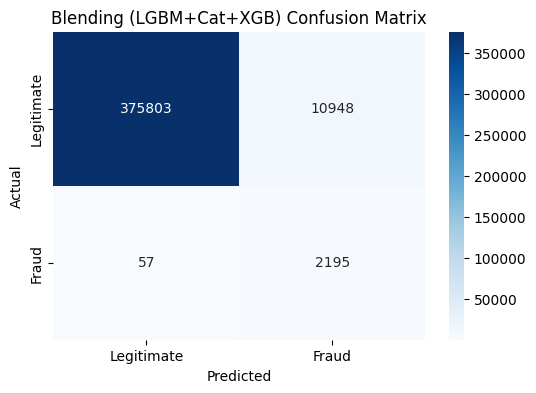

[LightGBM] [Info] Number of positive: 72193, number of negative: 721934
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.256282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24551
[LightGBM] [Info] Number of data points in the train set: 794127, number of used features: 1209
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000

Blending (All) Performance:
Accuracy: 0.9711
Precision: 0.1643 | Recall (Sensitivity): 0.9760
Specificity: 0.9711 | NPV: 0.9999
F1 Score: 0.2812 | MCC: 0.3943
ROC-AUC: 0.9966 | PR-AUC: 0.7569
False Positive Rate: 0.0289 | False Negative Rate: 0.0240
Confusion Matrix:
[[375568  11183]
 [    54   2198]]


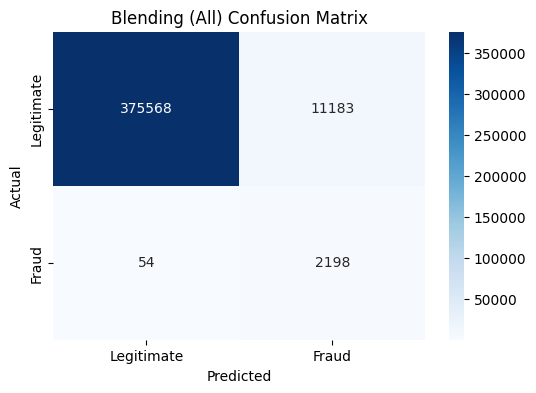


Evaluating Stacking (LGBM+XGB)...

Stacking (LGBM+XGB) Performance:
Accuracy: 0.9744
Precision: 0.1806 | Recall (Sensitivity): 0.9685
Specificity: 0.9744 | NPV: 0.9998
F1 Score: 0.3044 | MCC: 0.4124
ROC-AUC: 0.9970 | PR-AUC: 0.8316
False Positive Rate: 0.0256 | False Negative Rate: 0.0315
Confusion Matrix:
[[376855   9896]
 [    71   2181]]


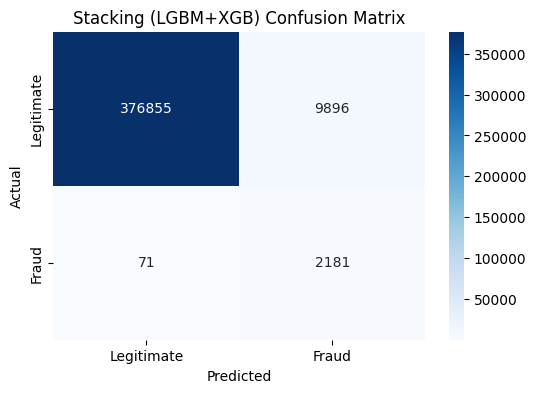


Evaluating Stacking (LGBM+Cat)...

Stacking (LGBM+Cat) Performance:
Accuracy: 0.9791
Precision: 0.2109 | Recall (Sensitivity): 0.9543
Specificity: 0.9792 | NPV: 0.9997
F1 Score: 0.3454 | MCC: 0.4434
ROC-AUC: 0.9966 | PR-AUC: 0.8268
False Positive Rate: 0.0208 | False Negative Rate: 0.0457
Confusion Matrix:
[[378709   8042]
 [   103   2149]]


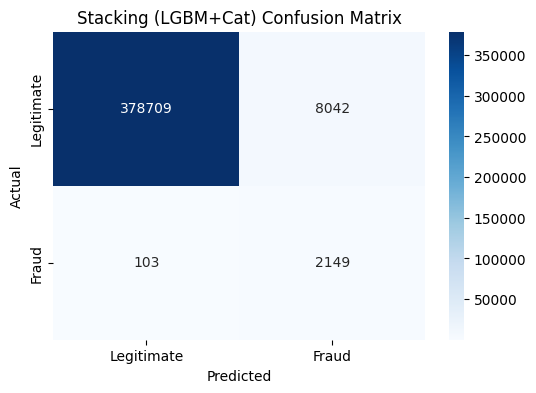


Evaluating Stacking (LGBM+Cat+XGB)...

Stacking (LGBM+Cat+XGB) Performance:
Accuracy: 0.9743
Precision: 0.1802 | Recall (Sensitivity): 0.9694
Specificity: 0.9743 | NPV: 0.9998
F1 Score: 0.3040 | MCC: 0.4122
ROC-AUC: 0.9969 | PR-AUC: 0.8273
False Positive Rate: 0.0257 | False Negative Rate: 0.0306
Confusion Matrix:
[[376822   9929]
 [    69   2183]]


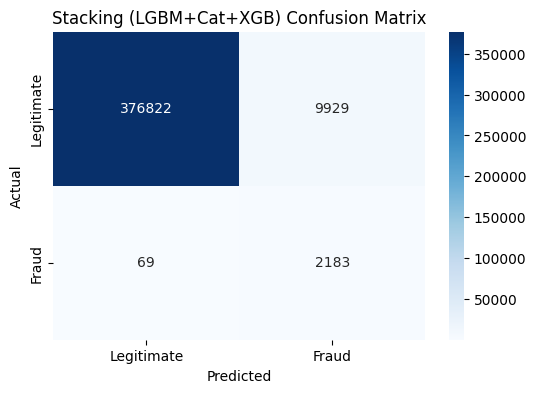


Evaluating Stacking (All)...

Stacking (All) Performance:
Accuracy: 0.9752
Precision: 0.1854 | Recall (Sensitivity): 0.9667
Specificity: 0.9753 | NPV: 0.9998
F1 Score: 0.3111 | MCC: 0.4177
ROC-AUC: 0.9962 | PR-AUC: 0.7146
False Positive Rate: 0.0247 | False Negative Rate: 0.0333
Confusion Matrix:
[[377186   9565]
 [    75   2177]]


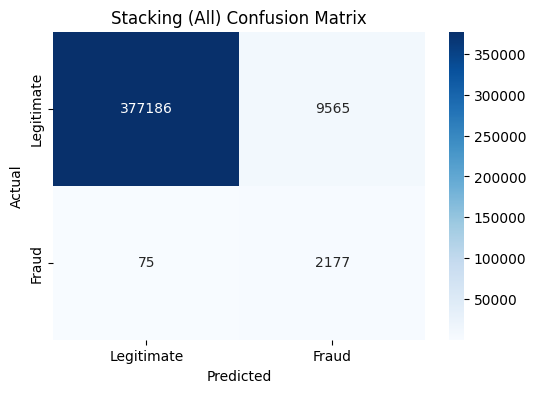

In [49]:
# Combine all results
results = []
all_curves = {}
for name, model in models.items():
    if 'Stacking' in name:
        continue  # We've already handled these
    elif 'Blending' in name:
        # Handle blending models
        try:
            y_pred_proba = blend_models(model, X_train, y_train, X_test)
            y_pred = (y_pred_proba > 0.5).astype(int)

             # Calculate curve data for blending models
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
            roc_auc = roc_auc_score(y_test, y_pred_proba)
            pr_auc = auc(recall, precision)

            all_curves[name] = {
                'fpr': fpr,
                'tpr': tpr,
                'precision': precision,
                'recall': recall,
                'auc': roc_auc,
                'pr_auc': pr_auc
            }

            class DummyModel:
                def predict_proba(self, X):
                    return np.column_stack([1-y_pred_proba, y_pred_proba])
                def predict(self, X):
                    return y_pred

            result = evaluate_model(DummyModel(), X_test, y_test, name)
            if result is not None:
                results.append(result)
                all_curves[name] = result['curve_data']
        except Exception as e:
            print(f"Error evaluating {name}: {str(e)}")
            continue
    else:
        try:
            result = evaluate_model(model, X_test, y_test, name)
            if result is not None:
                results.append(result)
                all_curves[name] = result['curve_data']
        except Exception as e:
            print(f"Error evaluating {name}: {str(e)}")
            continue

# Evaluate stacking models first with untransformed data
stacking_results = []
for name, model_dict in [('Stacking (LGBM+XGB)', stack_lgbm_xgb),
                         ('Stacking (LGBM+Cat)', stack_lgbm_cat),
                         ('Stacking (LGBM+Cat+XGB)', stack_lgbm_cat_xgb),
                         ('Stacking (All)', stack_all)]:
    print(f"\nEvaluating {name}...")
    try:
        y_pred_proba = custom_stacking(model_dict, X_train, y_train, X_test)
        y_pred = (y_pred_proba > 0.5).astype(int)

        class DummyModel:
            def predict_proba(self, X):
                return np.column_stack([1-y_pred_proba, y_pred_proba])
            def predict(self, X):
                return y_pred

        result = evaluate_model(DummyModel(), X_test, y_test, name)
        if result is not None:
            stacking_results.append(result)
            all_curves[name] = result['curve_data']
    except Exception as e:
        print(f"Error evaluating {name}: {str(e)}")
        continue


# Add stacking results collected earlier
for result in stacking_results:
    all_curves[result['Model']] = result['curve_data']
results.extend(stacking_results)
results_df = pd.DataFrame(results).drop(columns=['curve_data'])
results_df.set_index('Model', inplace=True)

## Summary of All Evaluation Metrics for All Models

In [50]:
# Create a formatted summary table
formatted_summary = results_df[['Accuracy', 'Precision', 'Recall', 'F1', 'MCC', 'ROC-AUC', 'PR-AUC']].copy()

# Format numbers to 6 decimal places
formatted_summary = formatted_summary.round(6)

# Add the model names as a column
formatted_summary.insert(0, 'Model', formatted_summary.index)

# Reset index to get rid of the Model index
formatted_summary = formatted_summary.reset_index(drop=True)

# Print the formatted table
from tabulate import tabulate
print("\n" + "="*80)
print("Summary of Results:")
print("="*80)
print(tabulate(formatted_summary, headers='keys', tablefmt='plain', showindex=False, floatfmt=".6f"))
print("="*80)


Summary of Results:
Model                      Accuracy    Precision    Recall        F1       MCC    ROC-AUC    PR-AUC
LightGBM                   0.984846     0.268581  0.938721  0.417663  0.497785   0.996623  0.825028
XGBoost                    0.936787     0.083371  0.992451  0.153820  0.278210   0.996643  0.820806
CatBoost                   0.987062     0.300014  0.926288  0.453232  0.523189   0.996244  0.824127
Logistic Regression        0.881698     0.037942  0.797957  0.072439  0.157797   0.916914  0.173219
Voting (LGBM+XGB)          0.981275     0.232055  0.967584  0.374334  0.469067   0.997597  0.844245
Voting (LGBM+Cat)          0.978969     0.212268  0.971137  0.348387  0.448914   0.997501  0.822435
Voting (LGBM+Cat+XGB)      0.980820     0.227933  0.968917  0.369049  0.465099   0.997632  0.838557
Voting (All)               0.983237     0.252177  0.964476  0.399816  0.488692   0.996573  0.717866
Blending (LGBM+XGB)        0.971784     0.167328  0.974245  0.285603  0.397679 

# 10. Result analysis

In [51]:
# Create a comprehensive scoring metric
results_df['Combined_Score'] = (0.25 * results_df['F1'] +
                               0.25 * results_df['MCC'] +
                               0.20 * results_df['ROC-AUC'] +
                               0.20 * results_df['PR-AUC'] +
                               0.10 * results_df['Accuracy'] +
                               0.10 * results_df['Recall'])

# Get top 3 models
top_models = results_df.nlargest(3, 'Combined_Score')

print("\n" + "="*80)
print("Top Performing Models:")
print("="*80)
for i, (_, row) in enumerate(top_models.iterrows(), 1):
    print(f"\n#{i}: {row.name}")
    print(f"Combined Score: {row['Combined_Score']:.4f}")
    print(f"Accuracy: {row['Accuracy']:.4f} | F1: {row['F1']:.4f} | MCC: {row['MCC']:.4f}")
    print(f"Precision: {row['Precision']:.4f} | Recall: {row['Recall']:.4f}")
    print(f"Specificity: {row['Specificity']:.4f} | NPV: {row['NPV']:.4f}")
    print(f"ROC-AUC: {row['ROC-AUC']:.4f} | PR-AUC: {row['PR-AUC']:.4f}")
print("="*80)


Top Performing Models:

#1: CatBoost
Combined Score: 0.7995
Accuracy: 0.9871 | F1: 0.4532 | MCC: 0.5232
Precision: 0.3000 | Recall: 0.9263
Specificity: 0.9874 | NPV: 0.9996
ROC-AUC: 0.9962 | PR-AUC: 0.8241

#2: LightGBM
Combined Score: 0.7855
Accuracy: 0.9848 | F1: 0.4177 | MCC: 0.4978
Precision: 0.2686 | Recall: 0.9387
Specificity: 0.9851 | NPV: 0.9996
ROC-AUC: 0.9966 | PR-AUC: 0.8250

#3: Voting (LGBM+XGB)
Combined Score: 0.7741
Accuracy: 0.9813 | F1: 0.3743 | MCC: 0.4691
Precision: 0.2321 | Recall: 0.9676
Specificity: 0.9814 | NPV: 0.9998
ROC-AUC: 0.9976 | PR-AUC: 0.8442


## Feature Importance and Model Analysis for the best model


LightGBM Feature Importance (from best model):
                    Feature  Importance
0                       amt         736
2                      hour         584
4                     month         151
700    category_food_dining         129
710   category_shopping_net         111
703    category_grocery_pos         110
708       category_misc_pos         103
3               day_of_week          93
705           category_home          86
699  category_entertainment          79
701  category_gas_transport          78
711   category_shopping_pos          73
712         category_travel          67
702    category_grocery_net          52
707       category_misc_net          49
1                  city_pop          48
706      category_kids_pets          45
709  category_personal_care          38
713                gender_F          22
884    job_Engineer, mining          17


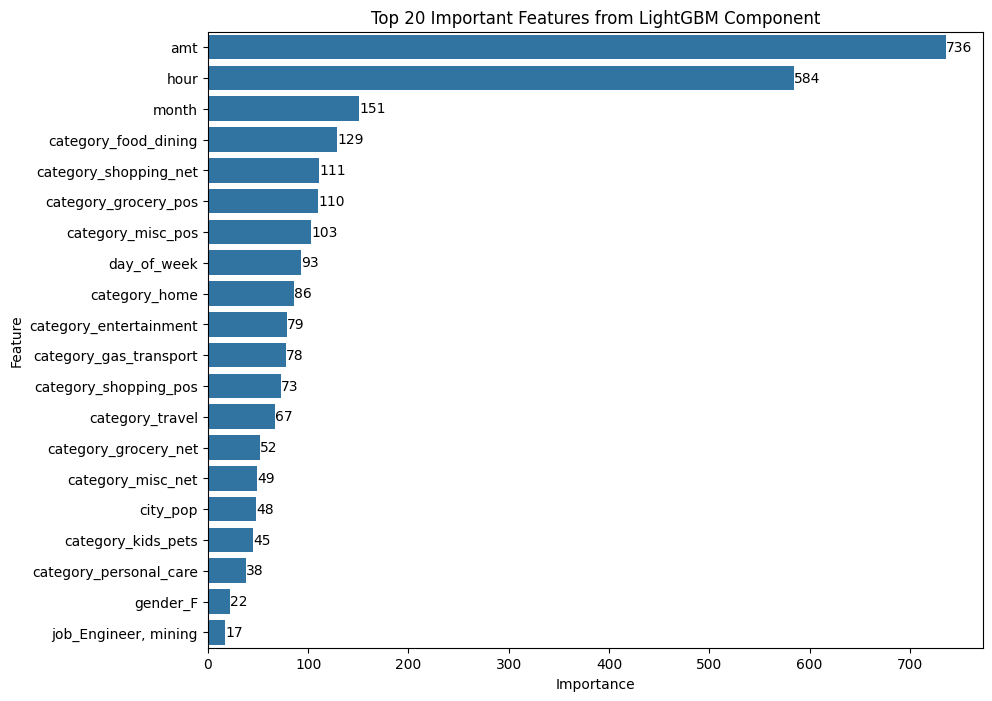

In [52]:
# Feature Importance and Model Analysis
best_model_name = top_models.index[0]


if 'LGBM' or 'LightGBM' in best_model_name:
    # Show LightGBM feature importance
    if 'Voting' in best_model_name:
        # For voting models, show feature importance from the LGBM component
        lgbm_model = models[best_model_name].estimators_[0]
        feature_names = numerical_features + \
                      list(lgbm_pipe.named_steps['preprocessor'].named_transformers_['cat'] \
                          .get_feature_names_out(categorical_features))

        importance = pd.DataFrame({
            'Feature': feature_names,
            'Importance': lgbm_model.feature_importances_
        }).sort_values('Importance', ascending=False)
    else:
        # For standalone LGBM
        importance = pd.DataFrame({
            'Feature': numerical_features + \
                      list(lgbm_pipe.named_steps['preprocessor'].named_transformers_['cat'] \
                          .get_feature_names_out(categorical_features)),
            'Importance': lgbm_pipe.named_steps['classifier'].feature_importances_
        }).sort_values('Importance', ascending=False)

    print("\nLightGBM Feature Importance (from best model):")
    print(importance.head(20))

    plt.figure(figsize=(10, 8))
    ax = sns.barplot(x='Importance', y='Feature', data=importance.head(20))
    plt.title('Top 20 Important Features from LightGBM Component')

    # Add importance values at the end of each bar
    for p in ax.patches:
        width = p.get_width()
        ax.text(width + 0.01,
                p.get_y() + p.get_height()/2.,
                '{:.0f}'.format(width),  # Changed to {:.0f} for whole numbers
                ha='left',
                va='center')
    plt.show()

elif 'Stacking' in best_model_name:
    # Show stacking coefficients
    print("\nStacking Model Coefficients:")
    # For our custom stacking, we need to fit it again to get coefficients
    final_estimator = LogisticRegression(class_weight='balanced', max_iter=1000)
    y_pred_proba = custom_stacking(models[best_model_name], X_train_transformed, y_train, X_test_transformed, final_estimator)

    coefs = final_estimator.coef_[0]
    for name, coef in zip(models[best_model_name].keys(), coefs):
        print(f"{name}: {coef:.4f}")

    plt.figure(figsize=(8, 4))
    ax = sns.barplot(x=list(models[best_model_name].keys()), y=coefs)
    plt.title('Stacking Model Weights')
    plt.ylabel('Coefficient')

    # Add coefficient values at the end of each bar
    for p in ax.patches:
        width = p.get_width()
        ax.text(width + 0.01,
                p.get_y() + p.get_height()/2.,
                '{:.0f}'.format(width),  # Changed to {:.0f} for whole numbers
                ha='left',
                va='center')
    plt.show()

## Visualization for Comparison

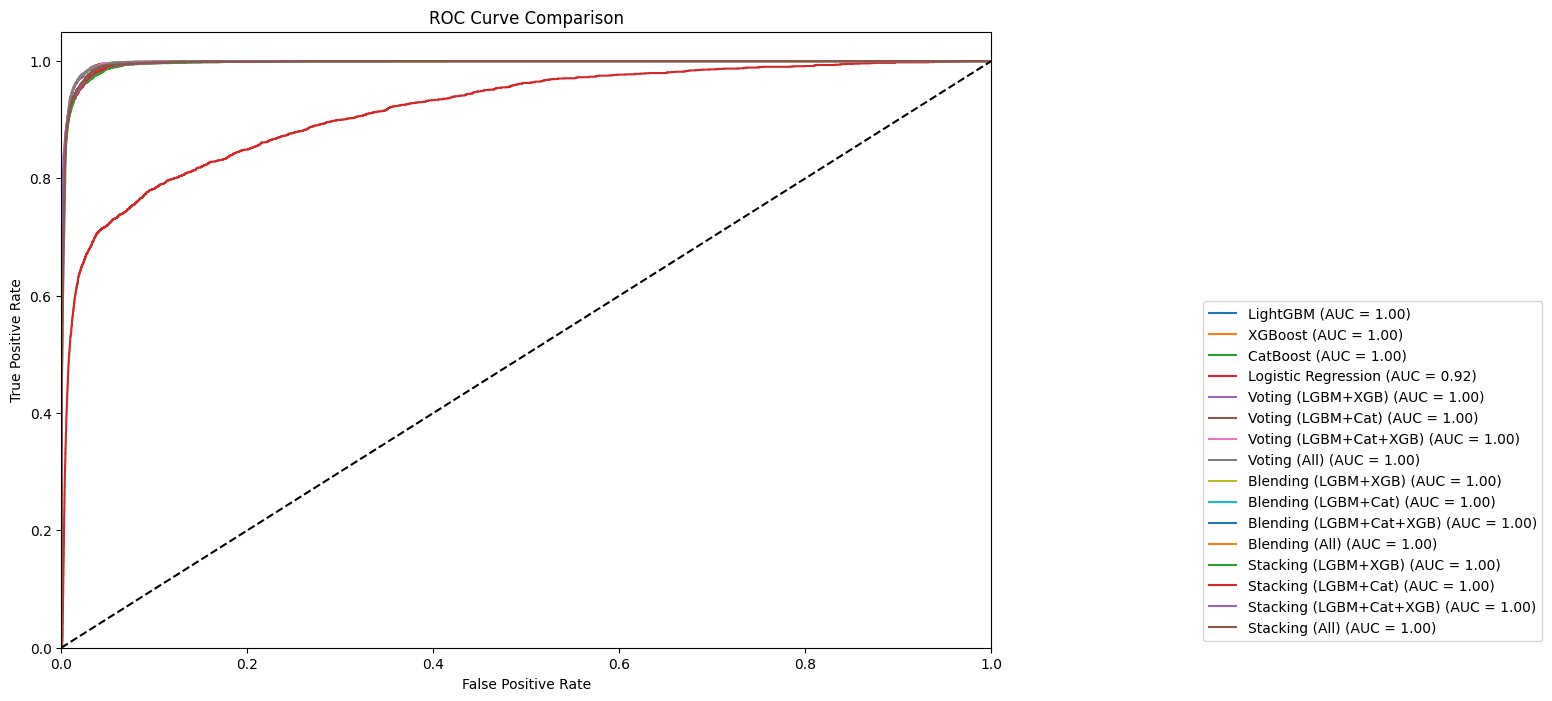

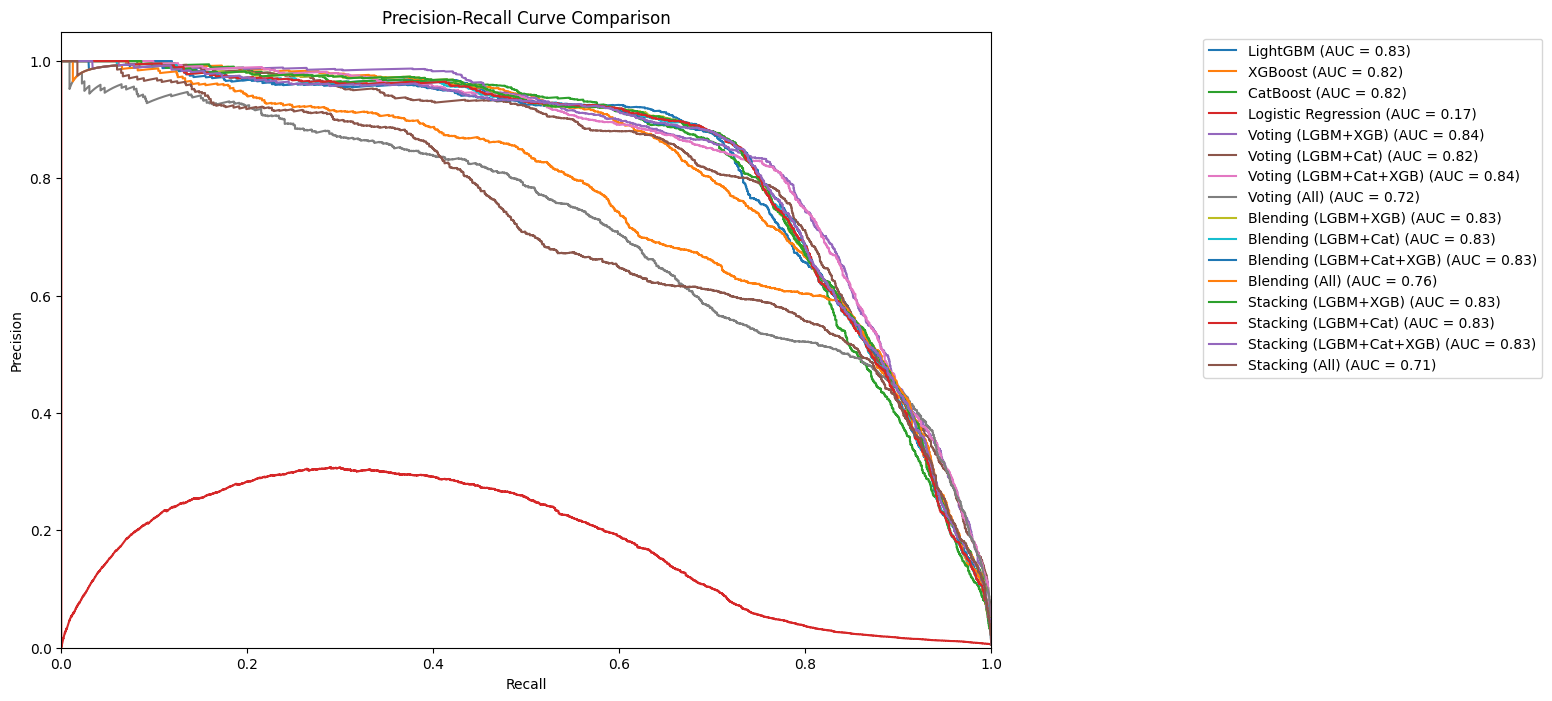

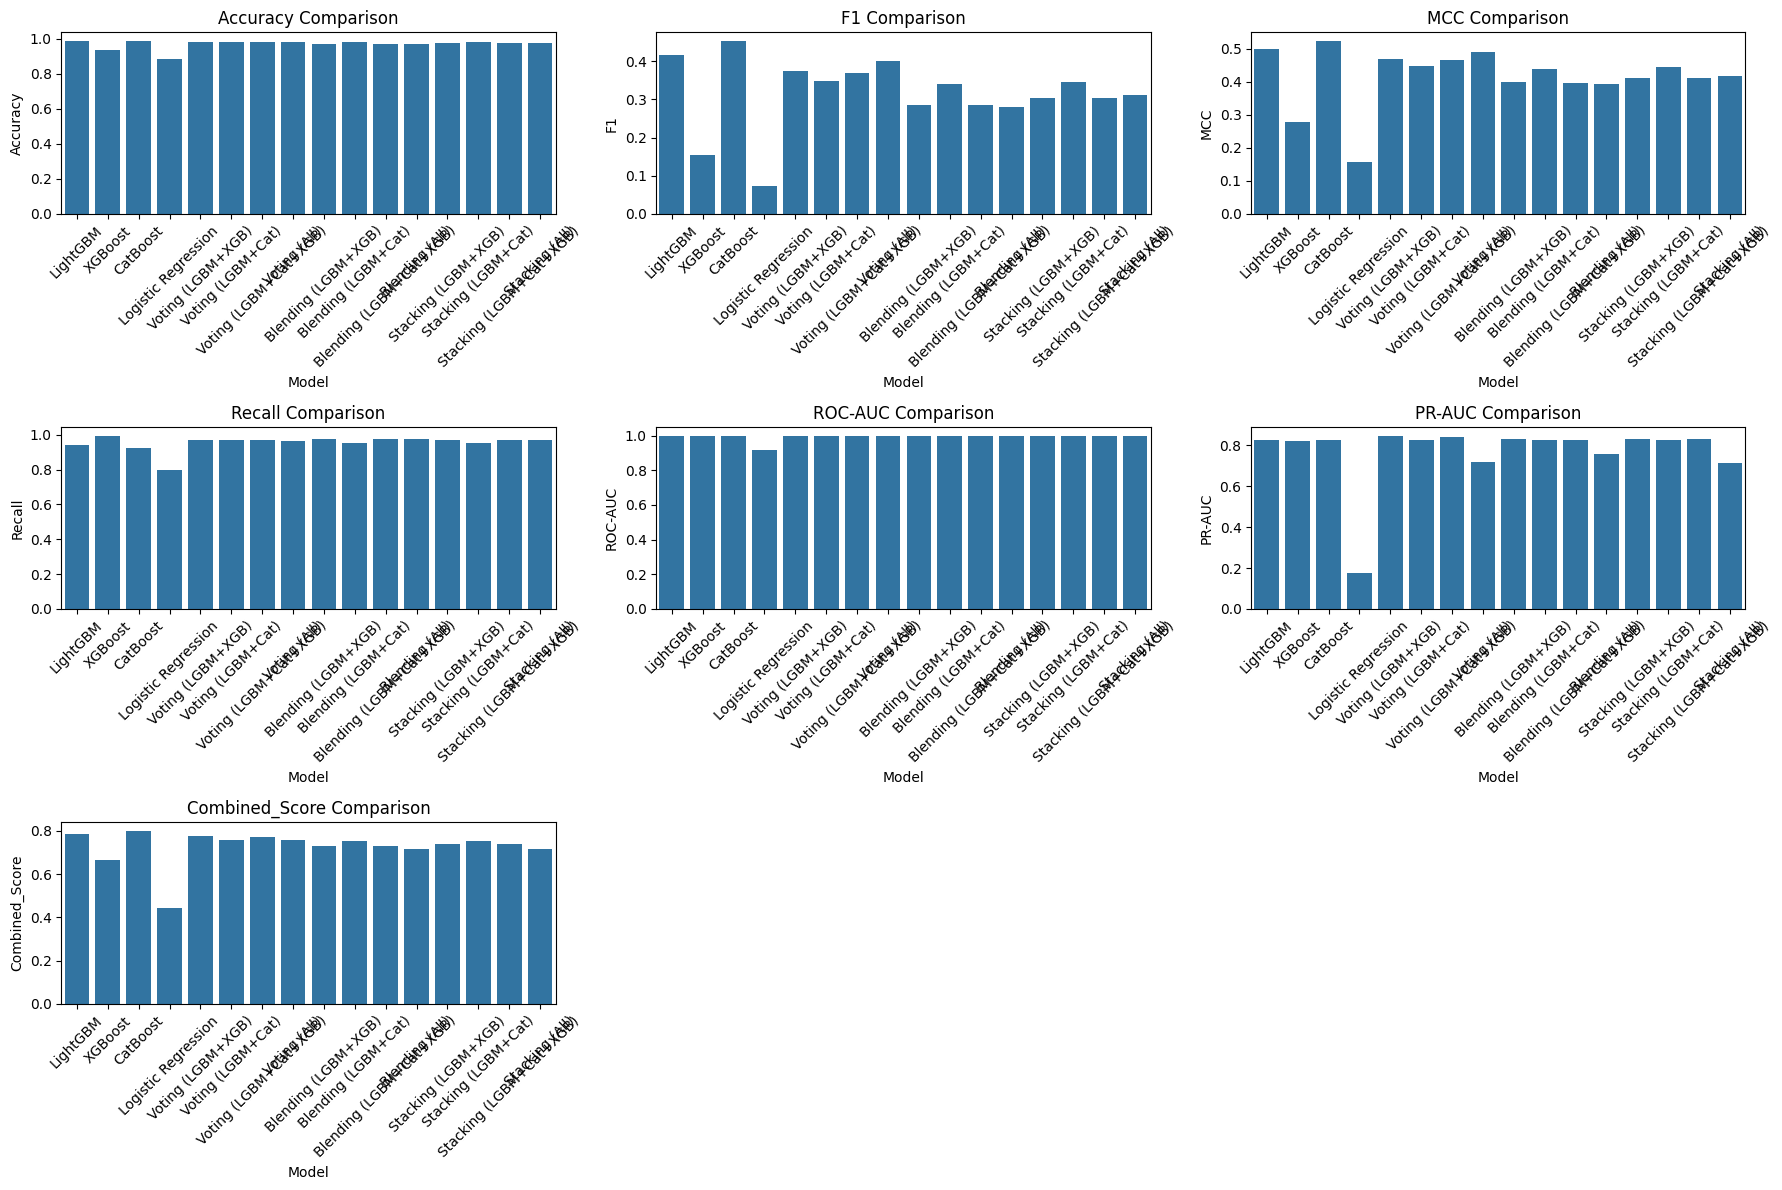

In [53]:
# 1. ROC Curve Comparison
plt.figure(figsize=(12, 8))
for name, data in all_curves.items():
    plt.plot(data['fpr'], data['tpr'],
             label=f'{name} (AUC = {data["auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right", bbox_to_anchor=(1.6, 0))
plt.show()

# 2. Precision-Recall Curve Comparison
plt.figure(figsize=(12, 8))
for name, data in all_curves.items():
    plt.plot(data['recall'], data['precision'],
             label=f'{name} (AUC = {data["pr_auc"]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend(loc="upper right", bbox_to_anchor=(1.6, 1))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

# 3. Metrics Comparison Bar Plot
metrics_to_plot = ['Accuracy', 'F1', 'MCC', 'Recall', 'ROC-AUC', 'PR-AUC', 'Combined_Score']
plt.figure(figsize=(18, 12))
for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(3, 3, i)
    sns.barplot(x=results_df.index, y=metric, data=results_df)
    plt.title(f'{metric} Comparison')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Show best model's performance metrics

In [54]:
# Show best model
results_df = results_df.sort_values('Combined_Score', ascending=False)
best_model = results_df.iloc[0]
print("\n=== Best Model ===")
print(f"Name: {best_model.name}")
print(f"Combined Score: {best_model['Combined_Score']:.4f}")
print(f"Accuracy: {best_model['Accuracy']:.4f}")
print(f"F1 Score: {best_model['F1']:.4f}")
print(f"MCC: {best_model['MCC']:.4f}")
print(f"Recall: {best_model['Recall']:.4f}")
print(f"ROC-AUC: {best_model['ROC-AUC']:.4f}")
print(f"PR-AUC: {best_model['PR-AUC']:.4f}")



=== Best Model ===
Name: CatBoost
Combined Score: 0.7995
Accuracy: 0.9871
F1 Score: 0.4532
MCC: 0.5232
Recall: 0.9263
ROC-AUC: 0.9962
PR-AUC: 0.8241


## Save result in csv file

In [55]:
# Save results
results_df.to_csv('best_model_fraud_detection.csv')
print("\nResults saved to csv file")


Results saved to csv file
